### Data Analysis and Modelling

In [1]:
import matplotlib as mpl 
import matplotlib.pyplot as plt 
import seaborn as sns 
import pandas as pd 
import numpy as np 
import scipy.stats as sp 

sns.set(font_scale = 3.0, style = 'ticks')
mpl.rcParams['figure.figsize'] = (15, 10)
sns.set_palette(sns.color_palette('colorblind'))
np.random.seed(42)

/Users/jonathac/anaconda3/envs/mm-venv/lib/python3.6/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Read in the data**

In [2]:
data = pd.read_csv('data/ues_subset_statistics.csv')
data.head()

,user_id,hidden_time,time_to_completion,reach_end,raw_session_length,session_length,SP,MP,LP,VLP,...,SEEK_BACKWARD_BUTTON_CLICKED,NEXT_BUTTON_CLICKED,BROWSER_VISIBILITY_CHANGE,USER_SET_VARIABLE,total_events,FA-Score,AE-Score,PU-Score,RW-Score,UES-Score
0,89183017-3e13-4660-b81d-19b193533f87,1.131,3578.471,True,3992.119,3990.988,3,0,0,2,...,2,0,4,0,109,4.67,5.00,4.67,4.67,4.75
1,caf711b5-2061-4b97-adc2-c7f8238aefdc,0.000,2938.767,True,3731.518,3731.518,0,0,0,1,...,0,0,0,0,92,4.00,4.00,3.00,5.00,4.00
2,e14ec5a0-e14a-4fa9-8264-7cbde6cbc2ad,0.429,3753.154,True,3958.807,3958.378,0,0,0,0,...,0,0,3,0,108,4.33,4.33,5.00,5.00,4.66
3,dce9a213-82cf-49e3-b209-6d3e9be5b964,0.000,2113.964,True,2631.837,2631.837,1,4,0,4,...,0,12,0,0,113,2.33,3.00,3.67,3.00,3.00
4,8c3fc22c-4fe4-4fca-a34f-d271fbace09b,0.000,2565.107,True,2766.776,2766.776,0,1,0,3,...,0,2,1,0,91,3.67,3.67,5.00,4.33,4.17


#### Data Preprocessing

In [6]:
# Any columns with all zeros?
print(f"Columns with only zero values: {list(data.loc[:, (data == 0).all()].columns)}")
data = data.drop(list(data.loc[:, (data == 0).all()].columns), axis = 1)
assert len(list(data.loc[:, (data == 0).all()].columns)) == 0

Columns with only zero values: ['SUBTITLES_BUTTON_CLICKED', 'VOLUME_CHANGE', 'USER_SET_VARIABLE']


In [7]:
# Any NaN values?
assert data.isnull().values.any() == False

In [8]:
# Convert time to completion and session length to minutes
data['time_to_completion'] = data['time_to_completion'].apply(lambda x: x / 60)
data['session_length'] = data['session_length'].apply(lambda x: x / 60)

In [9]:
# Rename the features to something more understandable
data = data.rename(columns = {
    'time_to_completion': 'Time to Completion', 'session_length': 'Session Length', 'SP': 'Short Pauses', 'MP': 'Medium Pauses', 
    'LP': 'Long Pauses', 'VLP': 'Very Long Pauses', 'FULLSCREEN_BUTTON_CLICKED': 'Fullscreen', 
    'LINK_CHOICE_CLICKED': 'Link Choices', 'NEXT_BUTTON_CLICKED': 'Next Button', 'NARRATIVE_ELEMENT_CHANGE': 'Narrative Element Changes', 
    'BROWSER_VISIBILITY_CHANGE': 'Browser Visibility Change', 'BACK_BUTTON_CLICKED': 'Back Button',
    'VIDEO_SCRUBBED': 'Video Scrub', 'WINDOW_ORIENTATION_CHANGE': 'Window Orientation Changes', 
    'PLAY_PAUSE_BUTTON_CLICKED': 'Play/Pause', 'SEEK_BACKWARD_BUTTON_CLICKED': 'Seek Backwards',
    'SEEK_FORWARD_BUTTON_CLICKED': 'Seek Forwards', 'total_events': 'Total Events'
})

In [11]:
# Binarize a select number of features - where there is a majority of zeros
features_to_binarize = ['Video Scrub', 'Window Orientation Changes', 'Seek Backwards', 'Seek Forwards']
for col in features_to_binarize:
    data[col] = np.where(data[col] == 0, 0, 1)
data[features_to_binarize[0]].value_counts(normalize = True)

0    0.586
1    0.414
Name: Video Scrub, dtype: float64

In [12]:
# Create the UES groups
med_ues = data['UES-Score'].median()
print(f"Median UES: {med_ues}")

data['UES-Group'] = np.where(data['UES-Score'] <= med_ues, 0, 1) # where 0 is 'low' and 1 is 'high'
data['UES-Group'].value_counts()

Median UES: 4.0


0    259
1    241
Name: UES-Group, dtype: int64

In [13]:
# Define the columns that we're going to use as features
features = [
    'Time to Completion', 'Session Length', 'Short Pauses', 'Medium Pauses', 'Long Pauses', 'Very Long Pauses', 
    'Fullscreen', 'Link Choices', 'Next Button', 'Narrative Element Changes', 'Browser Visibility Change', 'Back Button',
    'Play/Pause', 'Total Events', 'Video Scrub', 'Window Orientation Changes', 'Seek Backwards', 'Seek Forwards', 'UES-Group'
]

# Calculate the relative frequency of interaction events
relative_frequency_events = [
    'Short Pauses', 'Medium Pauses', 'Long Pauses', 'Very Long Pauses', 
    'Fullscreen', 'Link Choices', 'Next Button', 'Narrative Element Changes', 
    'Browser Visibility Change', 'Back Button', 'Play/Pause', 'Seek Backwards', 
    'Seek Forwards', 'Video Scrub', 'Window Orientation Changes'
]

for col in relative_frequency_events:
    data[col + ' (Relative Frequency)'] = data[col] / data[relative_frequency_events].sum(axis = 1) * 100

for col in relative_frequency_events:
    features.append(col + ' (Relative Frequency)')

#### Correlative Relationships

In [16]:
def get_significance_level(p):
    if p <= 0.001: return '*** (p < 0.001)'
    elif p <= 0.01: return '** (p < 0.01)'
    elif p <= 0.05: return '* (p < 0.05)'
    else: return 'p > 0.05'

def determine_normality(x):
    return sp.shapiro(x)[1] > 0.05

def find_relationships(dataframe, features_to_consider, engagement_column = 'UES-Score'):
    p_values = []
    feature_index = []
    
    # is the engagement score normally distributed?
    ues_norm = determine_normality(dataframe[engagement_column])
    
    for index, feature in enumerate(features_to_consider):
        if determine_normality(dataframe[feature]) and ues_norm:
            r, p = sp.pearsonr(dataframe[feature], dataframe[enagement_column])
            p_values.append(('p', r, p, feature, get_significance_level(p)))
        else:
            corr, p = sp.spearmanr(dataframe[feature], dataframe[engagement_column])
            p_values.append(('s', corr, p, feature, get_significance_level(p)))

        feature_index.append(feature)
    
    return p_values

In [17]:
pd.DataFrame(
    find_relationships(data, features),
    columns = ['method', 'corr', 'p_val', 'feature', 'sig_level']
).sort_values(by = 'corr', ascending = False)

,method,corr,p_val,feature,sig_level
18,s,0.866063,4.723560e-152,UES-Group,*** (p < 0.001)
1,s,0.324427,1.019187e-13,Session Length,*** (p < 0.001)
0,s,0.304415,3.509510e-12,Time to Completion,*** (p < 0.001)
9,s,0.285261,8.130701e-11,Narrative Element Changes,*** (p < 0.001)
7,s,0.135030,2.480713e-03,Link Choices,** (p < 0.01)
12,s,0.128841,3.904343e-03,Play/Pause,** (p < 0.01)
29,s,0.119938,7.255414e-03,Play/Pause (Relative Frequency),** (p < 0.01)
26,s,0.117698,8.429272e-03,Narrative Element Changes (Relative Frequency),** (p < 0.01)
6,s,0.105205,1.861807e-02,Fullscreen,* (p < 0.05)
13,s,0.099060,2.676245e-02,Total Events,* (p < 0.05)


***Are there statistical differences between the features, based on the UES Groups?***

In [18]:
from statsmodels.stats.multitest import multipletests
from pingouin import compute_effsize

def differences_between_features(data_x, data_y, features_to_consider):
    p_values = []
    stat_values = []
    feature_index = []
    
    for idx, feature in enumerate(features_to_consider):
        stat, p = sp.mannwhitneyu(x = data_x[feature], y = data_y[feature])
        p_values.append(p)
        stat_values.append(stat)
        feature_index.append(idx)
        
    reject, corrected_p_values, alpha_sidak, alpha_bonf = multipletests(
        p_values, alpha = 0.05, method = 'fdr_bh', is_sorted = False
    )
    
    significant_diff = []
    for idx, rej in enumerate(reject): # boolean array
        if rej:
            feat = features_to_consider[idx]
            effect_size = compute_effsize(x = data_x[feat], y = data_y[feat], eftype = 'CLES')
            significant_diff.append((
                feat, corrected_p_values[idx], 
                stat_values[idx], effect_size, 
                get_significance_level(corrected_p_values[idx]),
                round(data_x[feat].median(), 2),
                round(data_y[feat].median(), 2)
            ))
    
    return significant_diff

In [19]:
pd.DataFrame(
    differences_between_features(
        data[data['UES-Group'] == 0], # low
        data[data['UES-Group'] == 1], # high
        features
    ),
    columns = ['feature', 'p_val', 'stat', 'effect_size', 'significance_level', 'median_low', 'median_high']
)

,feature,p_val,stat,effect_size,significance_level,median_low,median_high
0,Time to Completion,3.190043e-07,22443.0,0.640446,*** (p < 0.001),34.95,46.74
1,Session Length,1.480689e-07,22111.0,0.645765,*** (p < 0.001),44.57,56.36
2,Link Choices,4.759202e-02,27724.5,0.541886,* (p < 0.05),29.00,31.00
3,Next Button,3.074373e-02,27466.0,0.415595,* (p < 0.05),2.00,0.00
4,Narrative Element Changes,8.222655e-06,23527.0,0.613115,*** (p < 0.001),54.00,62.00
5,Play/Pause,1.655141e-02,26982.5,0.415787,* (p < 0.05),0.00,2.00
6,UES-Group,2.688303e-109,0.0,1.000000,*** (p < 0.001),0.00,1.00
7,Medium Pauses (Relative Frequency),4.275907e-02,27640.0,0.480767,* (p < 0.05),1.15,0.84
8,Long Pauses (Relative Frequency),4.759202e-02,27897.0,0.431615,* (p < 0.05),0.72,0.00
9,Next Button (Relative Frequency),3.142102e-02,27541.0,0.429789,* (p < 0.05),1.33,0.00


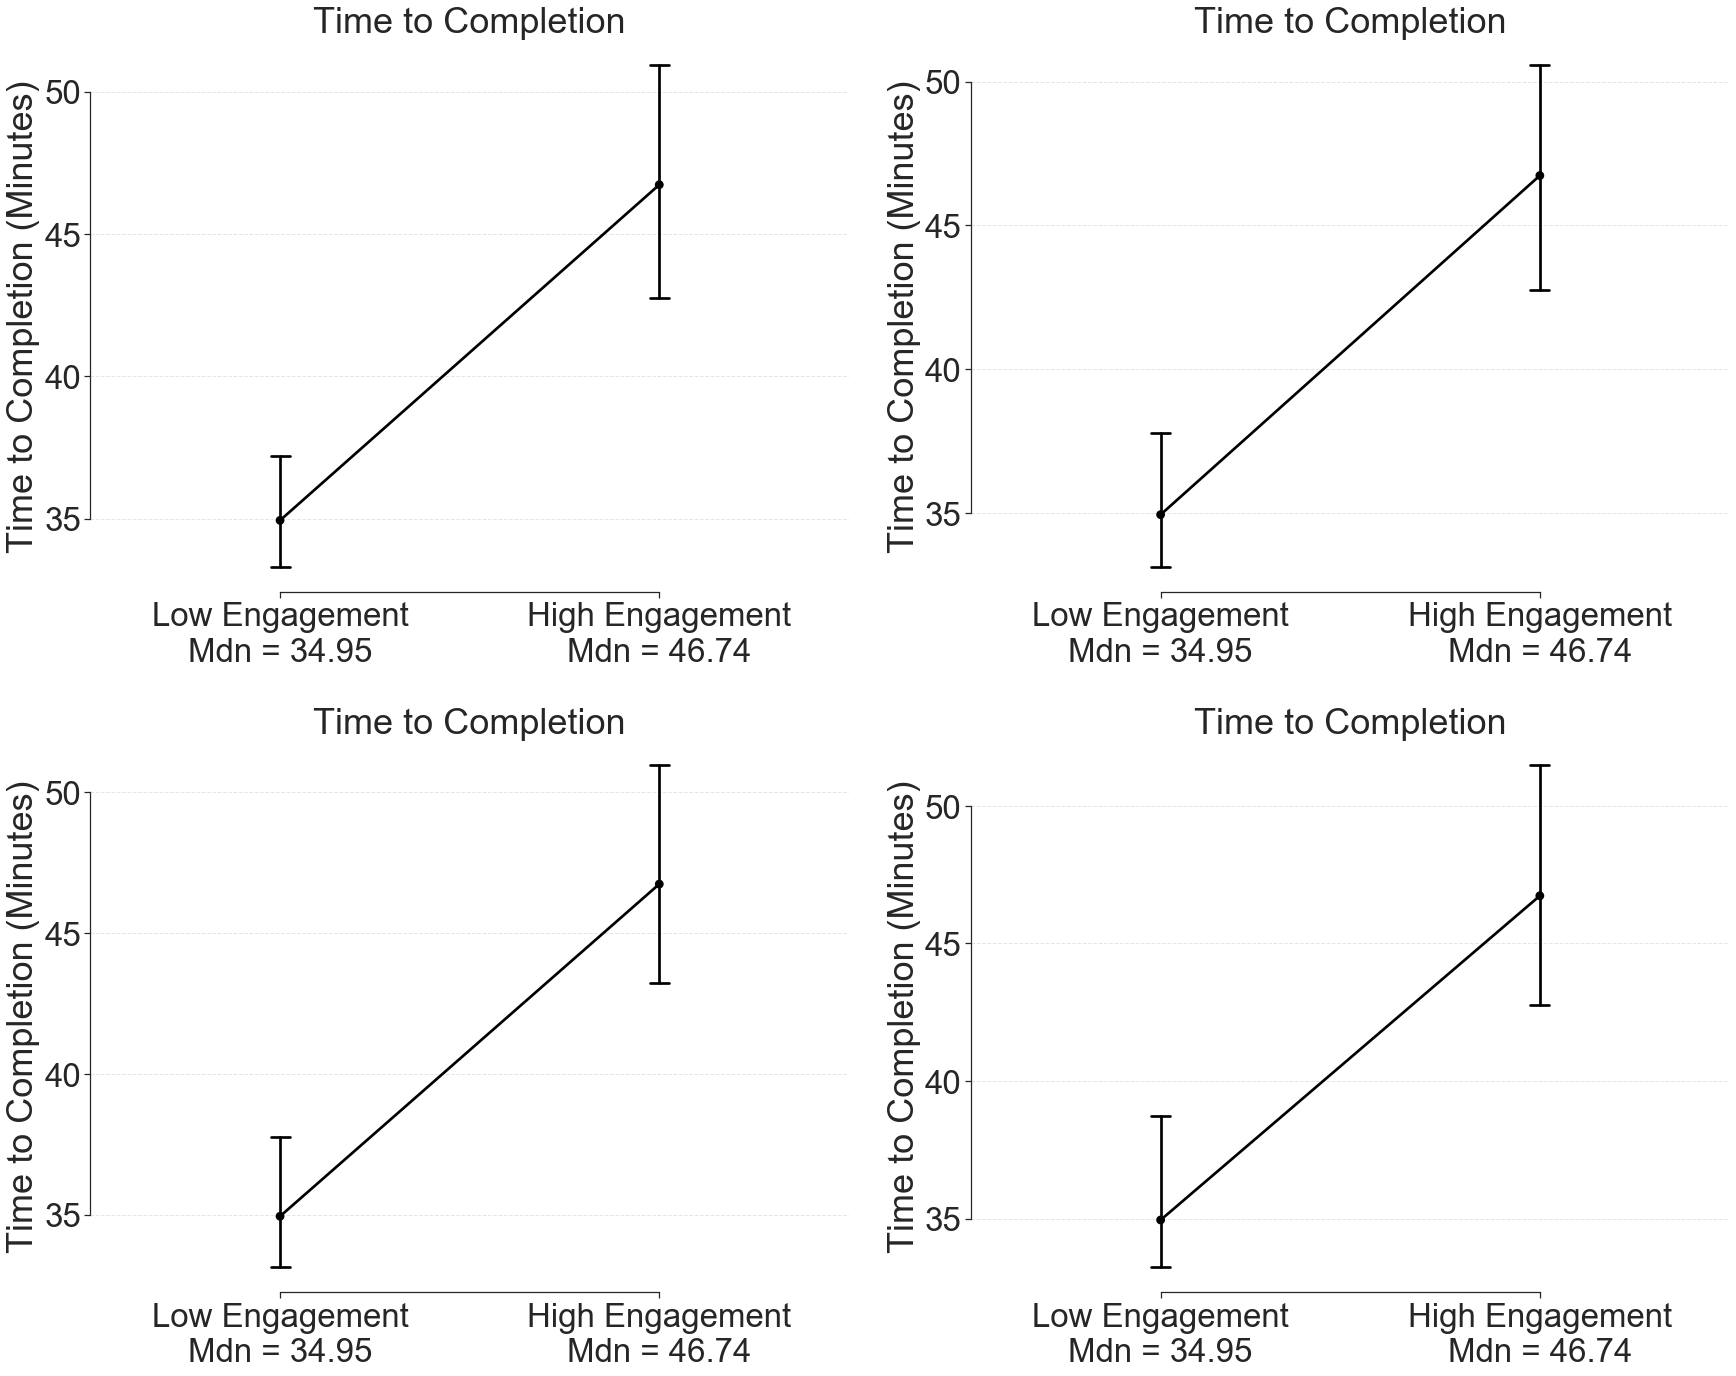

In [20]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (25, 20))
ax = ax.ravel()

for a in ax:
    p = sns.pointplot(
        data = [
            data[data['UES-Group'] == 0]['Time to Completion'], # low 
            data[data['UES-Group'] == 1]['Time to Completion'] # high
        ],
        estimator = np.median, capsize = 0.05, ax = a, color = 'black'
    )

    p.set(
        xticklabels = [
            f"Low Engagement\nMdn = {round(data[data['UES-Group'] == 0]['Time to Completion'].median(), 2)}", 
            f"High Engagement\nMdn = {round(data[data['UES-Group'] == 1]['Time to Completion'].median(), 2)}"
        ], 
        ylabel = 'Time to Completion (Minutes)'
    )
    p.title.set_text('Time to Completion')
    p.yaxis.grid(True, alpha = 0.5, linestyle = 'dashed')

sns.despine(trim = True)
plt.tight_layout()
plt.show()

**Chi-Square Test**

- Null Hypothesis: There are no detectable differences in the statistics between the two engagement classes (high & low)
- Alternative Hypothesis: There exists detectable differences in the frequent subsequences between two engagement classes (high & low)

In [21]:
# first, build the observed frequencies from the data
observed_frequencies = {'high': {}, 'low': {}}

mean_features = set([ # features that we want to take the mean of, rather than the count
    'Time to Completion', 'Session Length', 'Short Pauses (Relative Frequency)', 
     'Medium Pauses (Relative Frequency)', 'Long Pauses (Relative Frequency)', 
     'Very Long Pauses (Relative Frequency)', 'Fullscreen (Relative Frequency)', 
     'Link Choices (Relative Frequency)', 'Next Button (Relative Frequency)', 
     'Narrative Element Changes (Relative Frequency)', 'Browser Visibility Change (Relative Frequency)', 
     'Back Button (Relative Frequency)', 'Video Scrub (Relative Frequency)', 
     'Window Orientation Changes (Relative Frequency)', 'Play/Pause (Relative Frequency)', 
     'Seek Backwards (Relative Frequency)', 'Seek Forwards (Relative Frequency)'
])
for feat in features:
    if feat == 'UES-Group': continue
    
    if feat in mean_features:
        low_mean = data[data['UES-Group'] == 0][feat].mean()
        high_mean = data[data['UES-Group'] == 1][feat].mean()
        observed_frequencies['high'][feat] = high_mean
        observed_frequencies['low'][feat] = low_mean
    else:
        low_count = data[data['UES-Group'] == 0][feat].sum()
        high_count = data[data['UES-Group'] == 1][feat].sum()
        observed_frequencies['high'][feat] = high_count
        observed_frequencies['low'][feat] = low_count

observed_freq = pd.DataFrame.from_dict(observed_frequencies, orient = 'index')    
observed_freq.head()

,Time to Completion,Session Length,Short Pauses,Medium Pauses,Long Pauses,Very Long Pauses,Fullscreen,Link Choices,Next Button,Narrative Element Changes,...,Link Choices (Relative Frequency),Next Button (Relative Frequency),Narrative Element Changes (Relative Frequency),Browser Visibility Change (Relative Frequency),Back Button (Relative Frequency),Play/Pause (Relative Frequency),Seek Backwards (Relative Frequency),Seek Forwards (Relative Frequency),Video Scrub (Relative Frequency),Window Orientation Changes (Relative Frequency)
high,47.408960,58.602614,767,488,388,1296,350,8238,1464,14918,...,27.385139,3.986021,51.886674,2.300397,1.592081,2.324379,0.140998,0.191088,0.313402,0.205262
low,38.071621,55.458790,1230,731,566,1245,314,8559,2388,14626,...,26.890337,5.673271,49.793289,2.450951,1.534811,1.869832,0.114937,0.187419,0.357547,0.226249


In [22]:
# use the scipy library to calculate the contingency table from the observed frequencies
stat, p, dof, expected = sp.chi2_contingency(observed_freq.values)

print('Expected shape:', expected.shape)

# can we reject the null hypothesis? We'll set our critical value at 0.05 
if p <= 0.05:
    print('Dependent (reject H0)')
else:
    print('Independent (fail to reject H0)')
    
print('Degrees of Freedom:', dof)

Expected shape: (2, 33)
Dependent (reject H0)
Degrees of Freedom: 32


In [23]:
# Perform a chi-square test for each of the features and rank them by their discriminatory power
chi2_obs = np.array([ # get the observed frequencies for the two classes
    observed_freq.values[0], # high
    observed_freq.values[1] # low
])
chi2_exp = np.array([ # get the expected frequencies for the two classes
    expected[0], # high
    expected[1] # low
])

# perform the chi square test on the observed and expected frequencies
chiq, ps = sp.chisquare(f_obs = chi2_obs, f_exp = chi2_exp)

In [24]:
def residuals(observed, expected):
    return (observed - expected) / np.sqrt(expected)

res = residuals(observed_freq.values, expected)

In [25]:
# get the ranking for each feature
top_n_idx = chiq.argsort()[-len(chiq):][::-1]

top_n = []
for val in top_n_idx:
    sig_level = get_significance_level(ps[val])
    
    val_high_count = observed_freq[observed_freq.columns[val]][0]
    val_low_count = observed_freq[observed_freq.columns[val]][1]
    
    top_n.append((
        observed_freq.columns[val], # the feature
        chiq[val], # the chi-square statistic
        ps[val], # p-value
        sig_level, # the level of significance
        res[1][val], # Pearson's residual for low
        res[0][val], # Pearson's residual for high
        val_low_count, # count for the value in the low group
        val_high_count, # count for the value in the high group
        val_high_count - val_low_count # direction of the relationship (positive -> more frequent in high, negative -> more frequent in low)
    ))

chiq_df = pd.DataFrame(top_n, columns = ['feature', 'chi-square', 'p-value', 'significance', 'pr_L', 'pr_H', 'count_L', 'count_H', 'rel_direction'])
chiq_df[chiq_df['significance'] != 'p > 0.05']

,feature,chi-square,p-value,significance,pr_L,pr_H,count_L,count_H,rel_direction
0,Next Button,175.165931,5.507717e-40,*** (p < 0.001),9.232771,-9.482714,2388.0,1464.0,-924.0
1,Short Pauses,84.100795,4.701816e-20,*** (p < 0.001),6.397456,-6.570643,1230.0,767.0,-463.0
2,Narrative Element Changes,39.579577,3.149599e-10,*** (p < 0.001),-4.388770,4.507580,14626.0,14918.0,292.0
3,Medium Pauses,36.357139,1.642764e-09,*** (p < 0.001),4.206318,-4.320189,731.0,488.0,-243.0
4,Long Pauses,24.402498,7.816728e-07,*** (p < 0.001),3.446072,-3.539362,566.0,388.0,-178.0
5,Play/Pause,11.584519,6.650312e-04,*** (p < 0.001),-2.374358,2.438635,742.0,835.0,93.0
6,Very Long Pauses,5.563636,1.833729e-02,* (p < 0.05),-1.645457,1.690002,1245.0,1296.0,51.0
7,Fullscreen,4.351213,3.698261e-02,* (p < 0.05),-1.455165,1.494559,314.0,350.0,36.0


#### Prediction

In [26]:
# get the target 
y = data.pop('UES-Group')
features.remove('UES-Group')

# get the features 
X = data[features]

In [27]:
from sklearn.metrics import make_scorer, precision_score, recall_score
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, train_test_split, LeaveOneOut
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer, RobustScaler
from sklearn.decomposition import PCA
from sklearn.tree import DecisionTreeClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import GaussianNB

import warnings 
warnings.filterwarnings('ignore')

def compare_models(X, y, scaler = False, scaler_type = None, scoring = 'roc_auc', include_pca = False):
    models = [
        ('lr', LogisticRegression(solver = 'liblinear')),
        ('sgd', SGDClassifier()),
        ('nb', GaussianNB()),
        ('dt', DecisionTreeClassifier()),
        ('lda', LinearDiscriminantAnalysis()),
        ('knn', KNeighborsClassifier()),
        ('svm', SVC())
    ]
    
    results = []
    
    for name, model in models:
        k_fold = StratifiedKFold(n_splits = 10, random_state = 42, shuffle = True)
        if scaler:
            if scaler_type and scaler_type == 'mm': scaler = MinMaxScaler()
            elif scaler_type and scaler_type == 'robust': scaler = RobustScaler()
            elif scaler_type and scaler_type == 'norm': scaler = Normalizer()
            else: scaler = StandardScaler()
                
            if include_pca:
                pipe = make_pipeline(scaler, PCA(n_components = 2, random_state = 42), model)
            pipe = make_pipeline(scaler, model)
            cv_results = cross_val_score(pipe, X, y, cv = k_fold, scoring = scoring)
            results.append((name, cv_results.mean()))
        else:
            cv_results = cross_val_score(model, X, y, cv = k_fold, scoring = scoring)
            results.append((name, cv_results.mean()))

        return sorted(results, key = lambda tup: tup[1], reverse = True)

print('Non-Scaled Input')
c = compare_models(X, y)[0]
print(c[0])
print(c)

print('\nStandard Scaler Input')
c = compare_models(X, y, scaler = True)
print(c[0])
print(c)

print('\nMinMax Scaler Input')
c = compare_models(X, y, scaler = True, scaler_type = 'mm')
print(c[0])
print(c)

print('\nNormalizer Scaler Input')
c = compare_models(X, y, scaler = True, scaler_type = 'norm')
print(c[0])
print(c)

print("\nRobust Scaler")
c = compare_models(X, y, scaler = True, scaler_type = 'robust')
print(c[0])
print(c)

print('\nStandard Scaler + PCA')
c = compare_models(X, y, scaler = True, include_pca = True)
print(c[0])
print(c)

print('\nMinMax Scaler + PCA Input')
c = compare_models(X, y, scaler = True, scaler_type = 'mn', include_pca = True)
print(c[0])
print(c)

print('\nNormalizer + PCA Input')
c = compare_models(X, y, scaler = True, scaler_type = 'norm', include_pca = True)
print(c[0])
print(c)

Non-Scaled Input
lr
('lr', 0.5890166666666666)

Standard Scaler Input
('lr', 0.5992720512820513)
[('lr', 0.5992720512820513)]

MinMax Scaler Input
('lr', 0.6063258974358974)
[('lr', 0.6063258974358974)]

Normalizer Scaler Input
('lr', 0.6305156410256411)
[('lr', 0.6305156410256411)]

Robust Scaler
('lr', 0.5943048717948718)
[('lr', 0.5943048717948718)]

Standard Scaler + PCA
('lr', 0.5992720512820513)
[('lr', 0.5992720512820513)]

MinMax Scaler + PCA Input
('lr', 0.5992720512820513)
[('lr', 0.5992720512820513)]

Normalizer + PCA Input
('lr', 0.6305156410256411)
[('lr', 0.6305156410256411)]


In [28]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, shuffle = True, stratify = y)
print(x_train.shape, x_test.shape)

(400, 33) (100, 33)


In [29]:
# find the best parameters
param_grid = {'lr__penalty': ['l1', 'l2'], 'lr__C': [0.0001, 0.001, 0.01, 0.1, 1], 'lr__tol': [0.00001, 0.0001, 0.001, 0.01, 0.1]}
pipe = Pipeline([('scale', MinMaxScaler()), ('lr', LogisticRegression(solver = 'liblinear'))])

k_fold = StratifiedKFold(n_splits = 10)

scoring =  {
    'precision': make_scorer(precision_score, {'zero_division': 0}),
    'recall': make_scorer(recall_score, {'zero_division': 0}),
    'f1_score': make_scorer(f1_score, {'average': 'binary', 'zero_division': 0}),
    'roc_auc': make_scorer(roc_auc_score),
    'accuracy': make_scorer(accuracy_score)
}

gs = GridSearchCV(
    estimator = pipe,
    param_grid = param_grid,
    scoring = scoring,
    cv = k_fold,
    refit = 'roc_auc',
    return_train_score = True
).fit(x_train, y_train)


print('Best Score: {0}'.format(gs.best_score_))
print('Test score: {0}'.format(gs.score(x_test, y_test)))
print('Best params: {0}'.format(gs.best_params_))

Best Score: 0.5697994987468672
Test score: 0.6113782051282051
Best params: {'lr__C': 1, 'lr__penalty': 'l2', 'lr__tol': 1e-05}


We now know the best model: Logistic Regression, it's best parameters, and it's ability to generalise to an unseen dataset. Let's evaluate it's performance, using roc_auc and find the most important features.

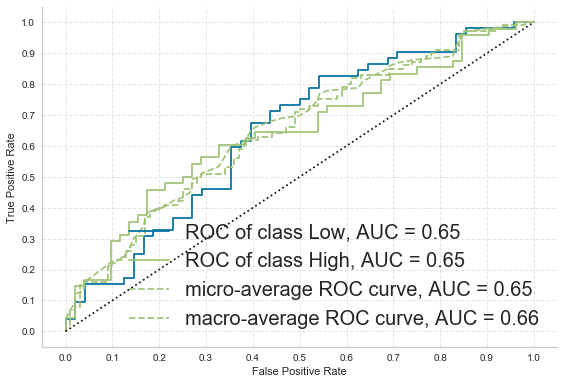

In [31]:
# reset the plotting libraries
import matplotlib.pyplot as plt 
import seaborn as sns

sns.set(font_scale = 3.0, style = 'ticks')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
mpl.rcParams['figure.figsize'] = (15, 10)
sns.set_palette(sns.color_palette('colorblind'))

from yellowbrick.classifier import ROCAUC

pipe = make_pipeline(MinMaxScaler(), LogisticRegression(solver = 'liblinear', penalty = 'l2', tol = 1e-05, C = 1))

fig, ax = plt.subplots()

visualizer = ROCAUC(pipe, classes=['Low', 'High'], title = " ", ax = ax)
visualizer.fit(x_train, y_train)
visualizer.score(x_test, y_test)

ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_xticks(np.arange(0.0, 1.1, step = 0.1))
ax.set_yticks(np.arange(0.0, 1.1, step = 0.1))
ax.legend(loc = 'lower right', prop = {'size': 20})

ax.grid(True, alpha = 0.5, linestyle = '--')

plt.tight_layout()
sns.despine()
plt.show()

In [32]:
from sklearn.metrics import classification_report

pipe = make_pipeline(MinMaxScaler(), LogisticRegression(solver = 'liblinear', penalty = 'l2', tol = 1e-05, C = 1))

pipe.fit(x_train, y_train)
y_pred = pipe.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.64      0.58      0.61        52
           1       0.58      0.65      0.61        48

    accuracy                           0.61       100
   macro avg       0.61      0.61      0.61       100
weighted avg       0.61      0.61      0.61       100



In [33]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='uniform', random_state = 42)
dummy_clf.fit(x_train, y_train)
y_pred = dummy_clf.predict(x_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.57      0.48      0.52        52
           1       0.52      0.60      0.56        48

    accuracy                           0.54       100
   macro avg       0.54      0.54      0.54       100
weighted avg       0.54      0.54      0.54       100



In [34]:
from mlxtend.evaluate import paired_ttest_5x2cv

pipe_one = make_pipeline(MinMaxScaler(), LogisticRegression(solver = 'liblinear', penalty = 'l2', tol = 1e-05, C = 1))
pipe_two = make_pipeline(MinMaxScaler(), DummyClassifier(strategy = 'uniform', random_state = 42))

t, p = paired_ttest_5x2cv(estimator1 = pipe_one, estimator2 = pipe_two, X = X, y = y, random_seed = 42, scoring = 'roc_auc')

print('t statistic: %.3f' % t)
print('p value: %.3f' % p)
print('significance level:', get_significance_level(p))

t statistic: 4.471
p value: 0.007
significance level: ** (p < 0.01)


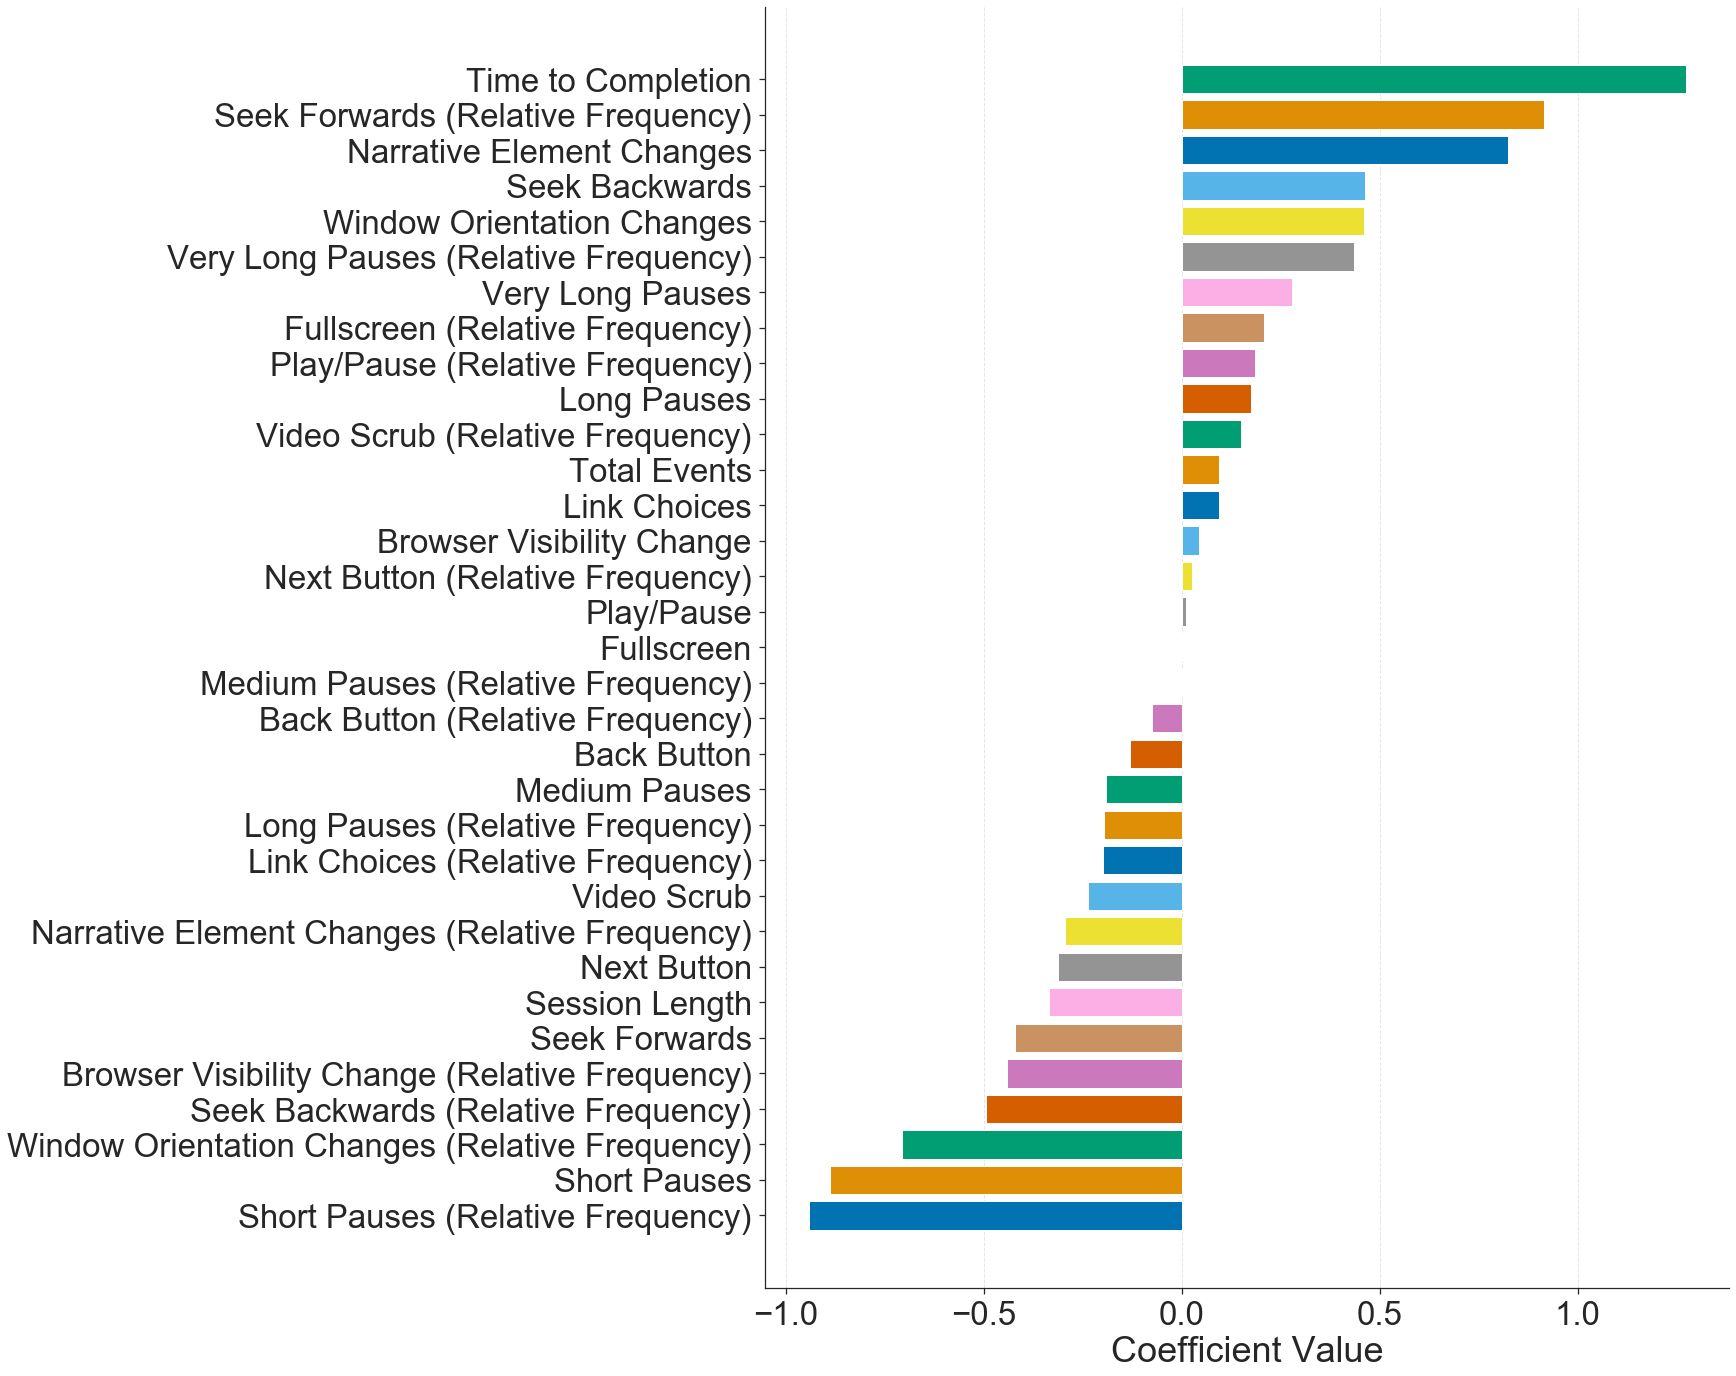

In [37]:
from yellowbrick.model_selection import FeatureImportances

sns.set(font_scale = 3, style = 'ticks')
sns.set_palette(sns.color_palette('colorblind'))

scaler = MinMaxScaler()
lr = LogisticRegression(solver = 'liblinear', penalty = 'l2', tol = 1e-05, C = 1)

fig, ax = plt.subplots(figsize = (25, 20))

data[features] = scaler.fit_transform(data[features])
viz = FeatureImportances(model = lr, relative = False, title = " ", ax = ax)
viz.fit(data[features], y)

ax.xaxis.grid(True, alpha = 0.5, linestyle = '--')
ax.set_xlabel('Coefficient Value')

sns.despine()
plt.tight_layout()
plt.show()

In [48]:
import shap 

x_train, x_test, y_train, y_test = train_test_split(data[features], y, test_size = 0.2, random_state = 42, shuffle = True, stratify = y)

In [49]:
lr = LogisticRegression(solver = 'liblinear', penalty = 'l2', tol = 1e-05, C = 1)
lr.fit(x_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=1e-05, verbose=0,
                   warm_start=False)

In [50]:
train_sample = shap.sample(x_train, 150)

explainer = shap.KernelExplainer(lr.predict_proba, train_sample)
shap_values = explainer.shap_values(x_test)

Using 150 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.
100%|██████████| 100/100 [02:15<00:00,  1.35s/it]


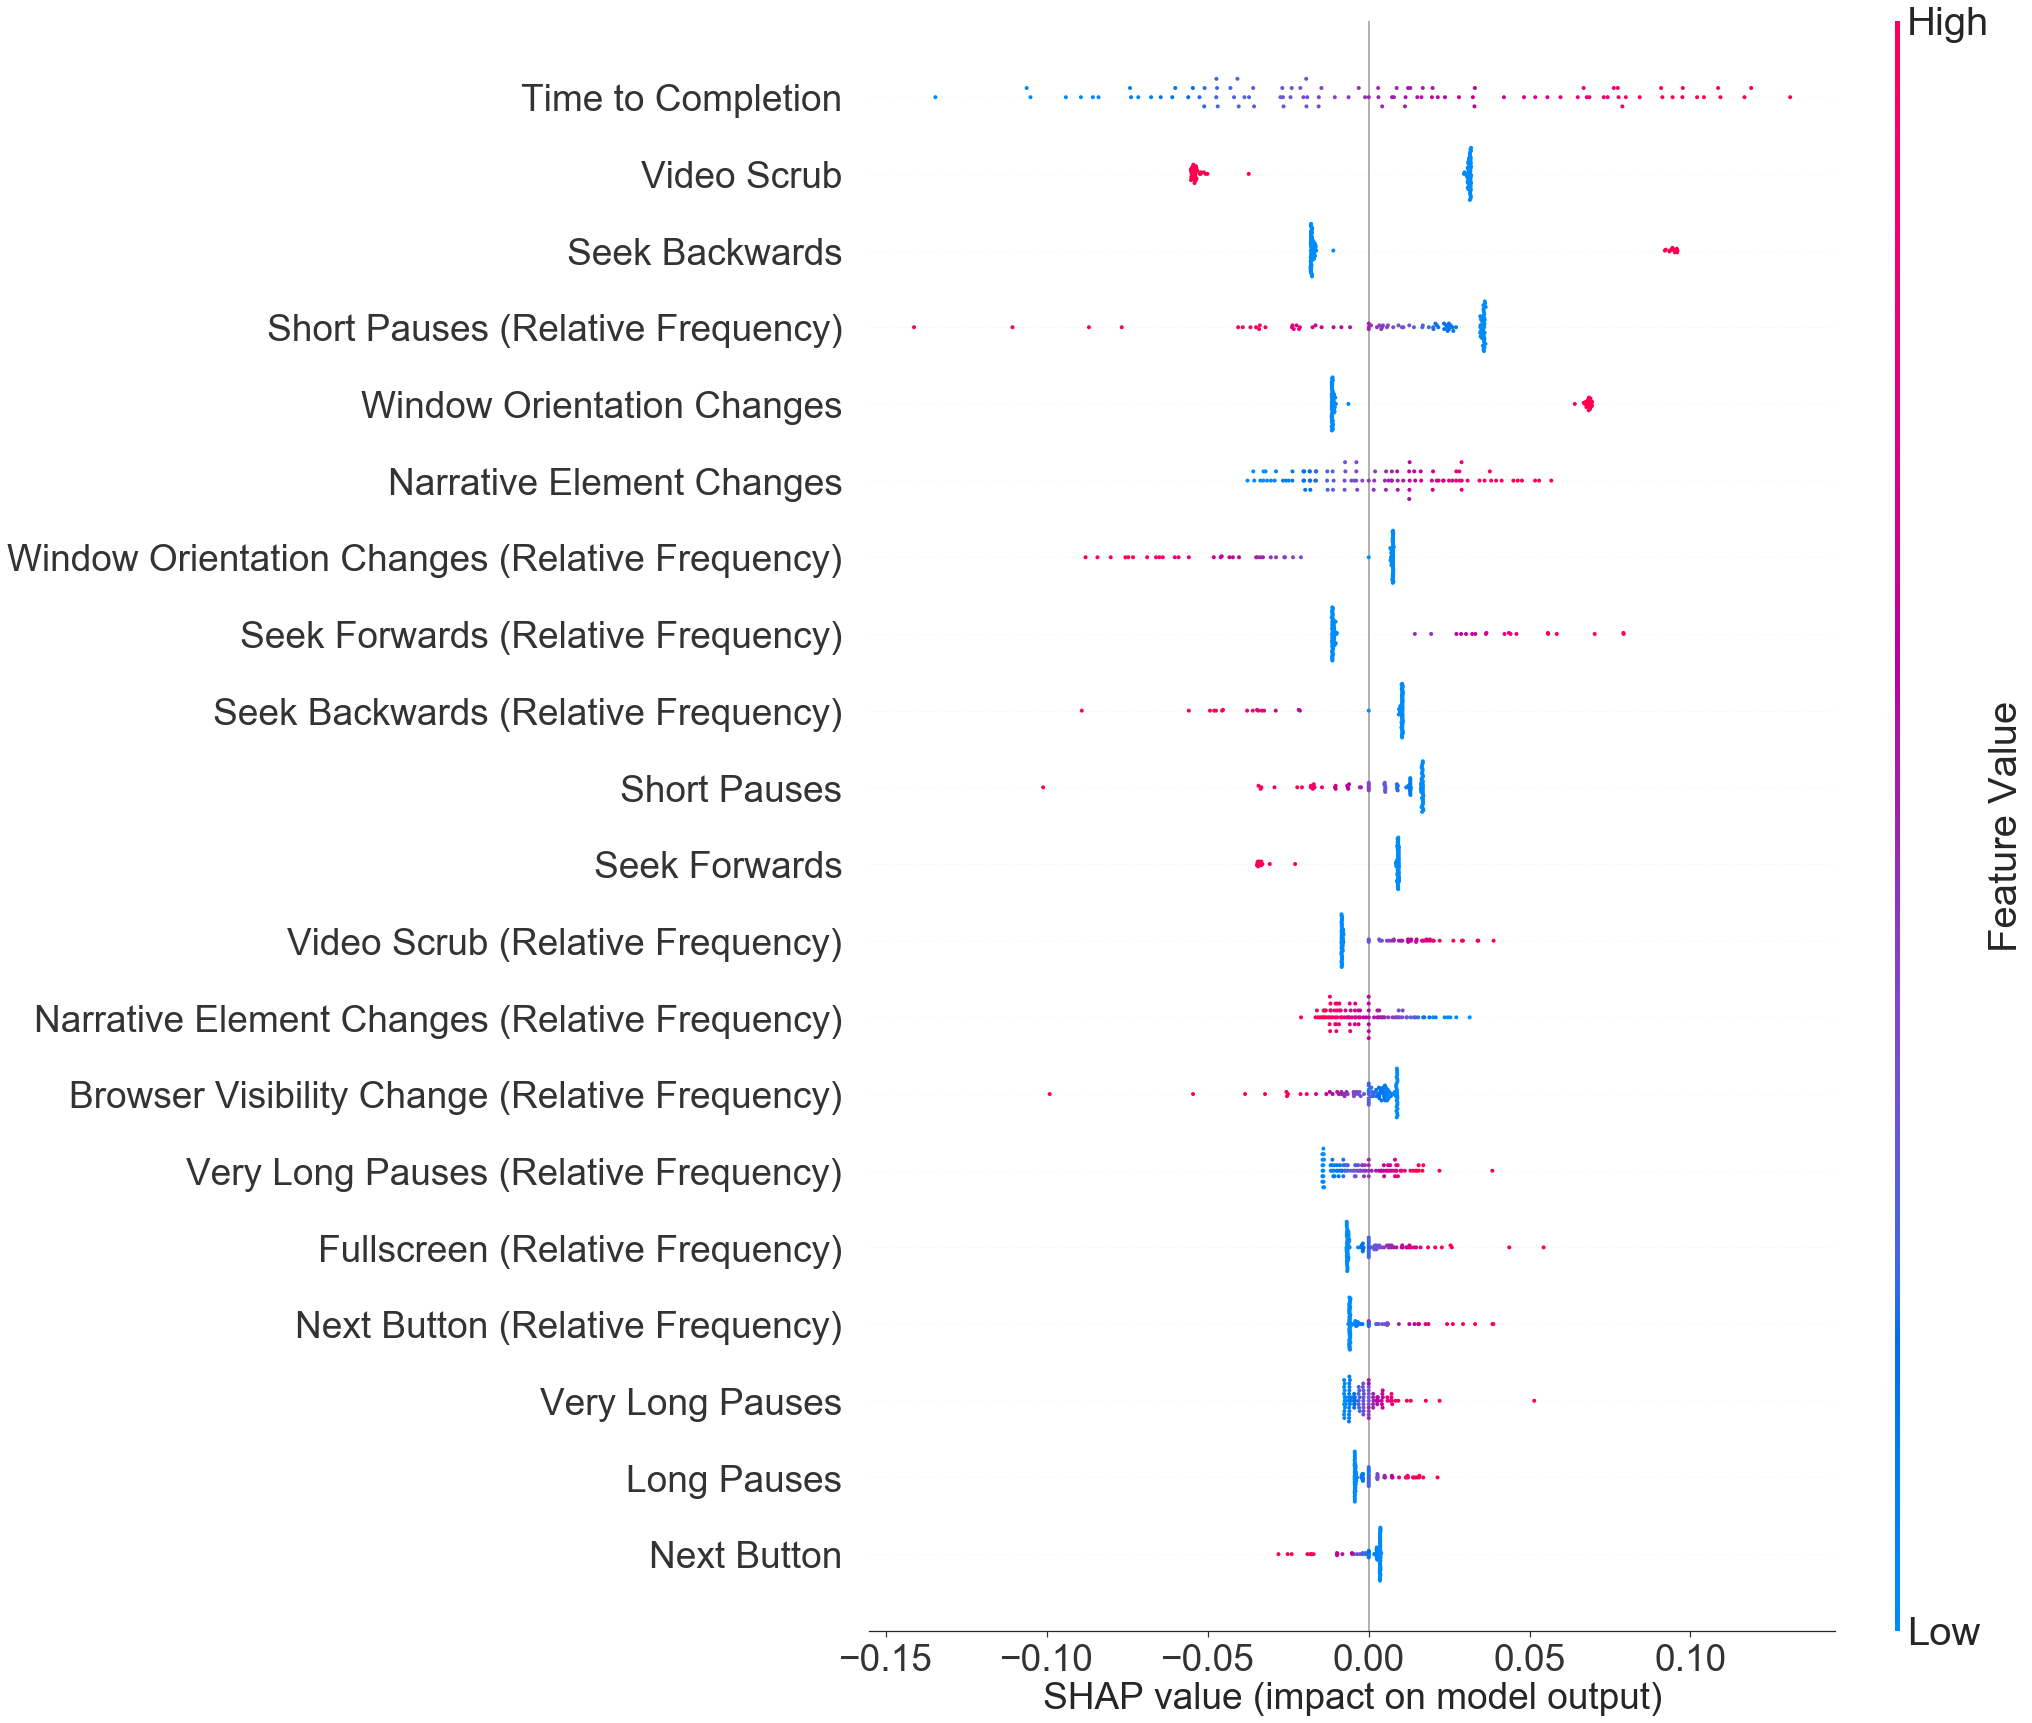

In [51]:
shap.summary_plot(shap_values[1], x_test, show = False, plot_size = (30, 25))
a = plt.gca()
f = plt.gcf()

for item in ([a.xaxis.label] + a.get_xticklabels() + a.get_yticklabels()):
    item.set_fontsize(37)

f.get_children()[2].get_children()[8].set_ticklabels(['Low', 'High'], fontsize = 40)
f.get_children()[2].get_children()[8].set_label_text('Feature Value', fontdict = {'size': 40})

plt.tight_layout()
plt.show()


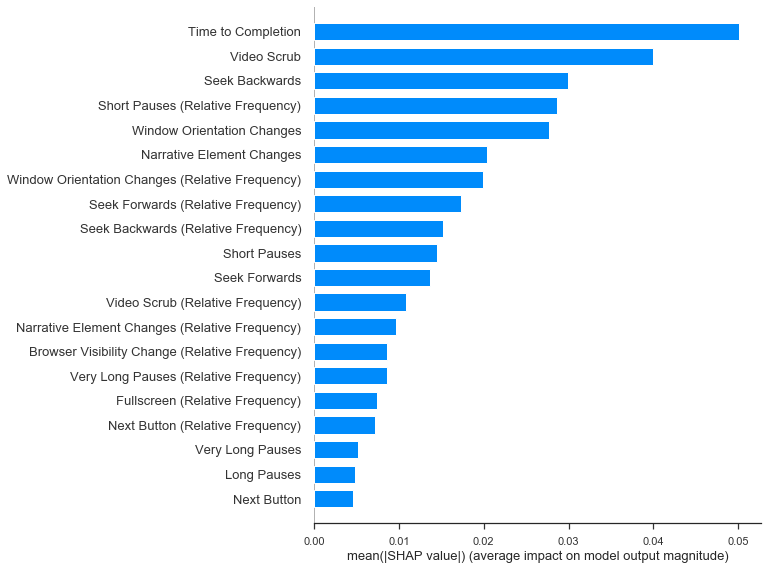

In [52]:
shap.summary_plot(shap_values[1], x_test, plot_type = 'bar')